In [1]:
import seaborn as sns
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import Orange
import numpy as np
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

# Load data

In [2]:
logfile_name = 'results.txt'
auroc_columns = ['Drug', 'Dataset', 'Auroc', 'Method']
auprc_columns = ['Drug', 'Dataset', 'Auprc', 'Method']
auroc_table_columns = ['Drug', 'Dataset', 'Auroc', 'Method']
auprc_table_columns = ['Drug', 'Dataset', 'Auprc', 'Method']

auroc_result_dataframe = pd.DataFrame(columns=auroc_columns)
auprc_result_dataframe = pd.DataFrame(columns=auprc_columns)
result_path = Path('..', 'results')
result_path_moli = result_path / 'moli'
result_path_super_felt = result_path / 'super.felt'
result_path_early_integration = result_path / 'early_integration'
result_path_stacking = result_path / 'stacking'
result_path_moma = result_path / 'moma'
result_path_omi_embed = result_path / 'omi_embed'
result_paths = [result_path_moli, result_path_super_felt, result_path_early_integration,
               result_path_stacking, result_path_moma, result_path_omi_embed]
method_folder = ['random_moli', 'random_super_felt', 'stacking_less',
                'moma_logistic', 'ei_without_triplets', 'omiEmbed_bce']

for result_path in result_paths:
    drug_paths =  [x for x in result_path.iterdir()]
    for drug_path in drug_paths:
        drug = drug_path.stem
        #method_folder = [path.stem for path in drug_path.iterdir()]
        for logfile_folder in method_folder:
            method = logfile_folder
            log_path = drug_path / logfile_folder / logfile_name
            test_aupcr = []
            extern_auprc = []
            if log_path.is_file():
                with open(log_path, 'r') as log_file:
                    for line in log_file:
                        if f'extern auroc mean' in line:
                            extern_auroc_mean = float(line.split(':')[-1])
                        if f'extern auprc mean' in line:
                            extern_auprc_mean = float(line.split(':')[-1])
                        if f'test auroc mean' in line:
                            test_auroc_mean = float(line.split(':')[-1])
                        if f'test auprc mean' in line:
                            test_auprc_mean = float(line.split(':')[-1])

                    auroc_result_dataframe = pd.concat((auroc_result_dataframe,
                        pd.DataFrame([[drug, f'Test', test_auroc_mean, method]], columns=auroc_columns)))
                    auroc_result_dataframe = pd.concat((auroc_result_dataframe,
                        pd.DataFrame([[drug, f'Extern', extern_auroc_mean, method]], columns=auroc_columns)))
                    auprc_result_dataframe = pd.concat((auprc_result_dataframe,
                        pd.DataFrame([[drug, f'Test', test_auprc_mean, method]], columns=auprc_columns)))
                    auprc_result_dataframe = pd.concat((auprc_result_dataframe,
                        pd.DataFrame([[drug, f'Extern', extern_auprc_mean, method]], columns=auprc_columns)))

## Beautify strings

In [3]:
rename_dict = {'random_moli': 'MOLI', 
               'random_super_felt': 'Super.FELT',
               'ei_without_triplets': 'Early Integration',
               'mobi': 'MOBI',
               'stacking_less': 'Omics Stacking',
               'moma_logistic': 'MOMA', 
               'omiEmbed_bce': 'OmiEmbed'
}

auroc_result_dataframe = auroc_result_dataframe.replace(rename_dict)
auprc_result_dataframe  = auprc_result_dataframe.replace(rename_dict)

## Calculate critical test difference

In [4]:
mean_results_df_auroc = auroc_result_dataframe.groupby(['Method', 'Drug', 'Dataset']).mean()
mean_results_df_auprc = auprc_result_dataframe.groupby(['Method', 'Drug', 'Dataset']).mean()


test_auroc_mean_results_df = mean_results_df_auroc.loc[:, :, 'Test']
test_auprc_mean_results_df = mean_results_df_auprc.loc[:, :, 'Test']


auroc_ranking_test = test_auroc_mean_results_df.groupby('Drug').rank(axis=0, ascending=False)\
.groupby(['Method']).mean()
auprc_ranking_test = test_auprc_mean_results_df.groupby('Drug').rank(axis=0, ascending=False)\
.groupby(['Method']).mean()

number_of_datasets  = 7
alpha='0.05'

In [5]:
auroc_ranking_test

,Auroc
Method,
Early Integration,5.142857
MOLI,3.857143
MOMA,2.833333
OmiEmbed,3.714286
Omics Stacking,2.714286
Super.FELT,2.285714


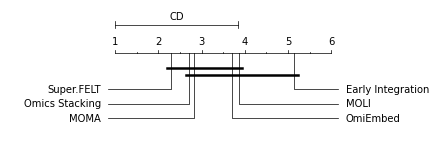

In [6]:
critical_difference = Orange.evaluation.compute_CD(auroc_ranking_test, 
                                                   number_of_datasets, alpha=alpha)
Orange.evaluation.graph_ranks(auroc_ranking_test.values.squeeze(), auroc_ranking_test.index,
                              cd=critical_difference, width=6, textspace=1.5)
plt.savefig('critical_difference_test_auroc.pdf', bbox_inches = "tight")

In [7]:
auprc_ranking_test

,Auprc
Method,
Early Integration,5.000000
MOLI,2.714286
MOMA,3.833333
OmiEmbed,4.428571
Omics Stacking,2.142857
Super.FELT,2.571429


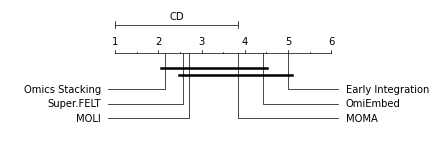

In [8]:
critical_difference = Orange.evaluation.compute_CD(auprc_ranking_test, number_of_datasets, alpha=alpha)
Orange.evaluation.graph_ranks(auprc_ranking_test.values.squeeze(), auprc_ranking_test.index, 
                              cd=critical_difference, width=6, textspace=1.5)
plt.savefig('critical_difference_test_auprc.pdf', bbox_inches = "tight")

## Calculate critical extern difference

In [9]:
mean_results_df_auroc = auroc_result_dataframe.groupby(['Method', 'Drug', 'Dataset']).mean()
mean_results_df_auprc = auprc_result_dataframe.groupby(['Method', 'Drug', 'Dataset']).mean()


extern_auroc_mean_results_df = mean_results_df_auroc.loc[:, :, 'Extern']
extern_auprc_mean_results_df = mean_results_df_auprc.loc[:, :, 'Extern']

auroc_ranking_extern = extern_auroc_mean_results_df.groupby('Drug').rank(axis=0, ascending=False)\
.groupby(['Method']).mean()
auprc_ranking_extern = extern_auprc_mean_results_df.groupby('Drug').rank(axis=0, ascending=False)\
.groupby(['Method']).mean()

In [10]:
auroc_ranking_extern

,Auroc
Method,
Early Integration,4.571429
MOLI,3.000000
MOMA,3.500000
OmiEmbed,4.857143
Omics Stacking,1.857143
Super.FELT,2.857143


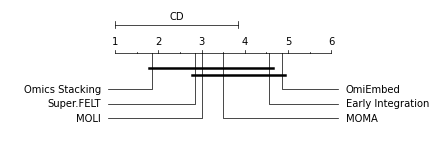

In [11]:
critical_difference = Orange.evaluation.compute_CD(auroc_ranking_extern, 
                                                   number_of_datasets, alpha=alpha)
Orange.evaluation.graph_ranks(auroc_ranking_extern.values.squeeze(),
                              auroc_ranking_extern.index,
                              cd=critical_difference, width=6, textspace=1.5)
plt.savefig('critical_difference_extern_auroc.pdf', bbox_inches = "tight")

In [12]:
auprc_ranking_extern

,Auprc
Method,
Early Integration,4.571429
MOLI,2.428571
MOMA,3.500000
OmiEmbed,4.714286
Omics Stacking,2.142857
Super.FELT,3.285714


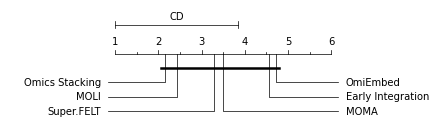

In [13]:
critical_difference = Orange.evaluation.compute_CD(auprc_ranking_extern, number_of_datasets, alpha=alpha)
Orange.evaluation.graph_ranks(auprc_ranking_extern.values.squeeze(), 
                              auprc_ranking_extern.index, cd=critical_difference, \
                              width=6, textspace=1.5)
plt.savefig('critical_difference_extern_auprc.pdf', bbox_inches = "tight")